In [9]:
#!/usr/bin/env python
from utils.file_operations import input_parse
from utils.simulation_helper import set_mesh_geometry
from utils.analysis.make_movies import write_movies_two_component_2d
import os
import argparse
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import  ConvexHull
import scipy.interpolate as interp
from sklearn.cluster import DBSCAN
from pathlib import Path
from typing import Union, Optional
import matplotlib as mpl
from scipy.ndimage import gaussian_filter1d
from utils import plot

In [3]:
class simDir:
    def __init__(self,
                 directory: str,
                 movie_parameters: str = "movie_parameters.txt"):
        self.directory = Path(directory)

        # Parse simulation parameter input. Simulation directories have this file by
        # default.
        self.params_file: str = self.directory / "input_params.txt"
        self.params = input_parse(self.params_file)

        # Simulation directories have this file by default.
        self.hdf5_file: str =  self.directory / "spatial_variables.hdf5"

        # Parse movie parameter input.
        self.movie_params_file = movie_parameters
        if os.path.isfile(self.movie_params_file):
            self.movie_params = input_parse(self.movie_params_file)
        else:
            print("Using default movie parameters.")
            self.movie_params = {'num_components': 2.0,
                                 'color_map': ['Blues', 'Reds'],
                                 'titles': ['Protein', 'RNA'],
                                 'figure_size': [15, 6]}

    def run(self, geo: bool=True, hdf5: bool=True,
            plot_limits: bool=True, condensate: bool=True):
        if geo:
            # Load Gmsh geometry
            self.geometry = set_mesh_geometry(self.params)
            self.xy = np.vstack((self.geometry.mesh.x, self.geometry.mesh.y)).T
        if hdf5:
            # Load concentration profile
            with h5py.File(self.hdf5_file, mode="r") as concentration_dynamics:
                # Read concentration profile data from files
                self.concentration_profile = []
                for i in range(int(self.movie_params['num_components'])):
                    conc_arr = concentration_dynamics[f'c_{i}'][:]
                    conc_arr = conc_arr[~np.all(conc_arr == 0, axis=1)]
                    self.concentration_profile.append(conc_arr)
            self.n_frames = len(self.concentration_profile[0])
        if plot_limits:
            self.getPlotLimits()

    def makeSubdirectory(self, subdirectory:str):
        # Make a directory within the simulation directory
        subdir_path = self.directory / subdirectory
        subdir_path.mkdir(exist_ok=True)
        return subdir_path

    def getPlotLimits(self):
        # Get upper and lower limits of the concentration values from the concentration profile data
        self.plotting_range = []
        conc = self.concentration_profile
        for i in range(int(self.movie_params['num_components'])):
            # Check if plotting range is explicitly specified in movie_parameters
            if 'c{index}_range'.format(index=i) in self.movie_params.keys():
                self.plotting_range.append(self.movie_params['c{index}_range'.format(index=i)])
            else:
                min_value = conc[i].min()
                max_value = conc[i].max()
                self.plotting_range.append([min_value, max_value])

    def makeMovie(self):
        write_movies_two_component_2d(self.directory,
                                      self.hdf5_file,
                                      self.movie_params,
                                      self.geometry.mesh)
    def makeFigure(self,
                   i:int,
                   n_rows:int=4,
                   n_cols:int=4):
        n_frames = n_rows*n_cols
        subdir_path = self.makeSubdirectory("figures")
        frames = np.linspace(0, self.concentration_profile[0].shape[0]-1, num=n_frames, dtype=int)
        fig = plt.figure(figsize=(6*(n_rows),6*(n_cols)))
        gs = fig.add_gridspec(n_rows,n_cols)
        axes = [fig.add_subplot(gs[i,j]) for i in range(n_cols) for j in range(n_rows)]
        for t, frame in enumerate(frames):
            # Generate and save plots
            # axes = axes.flatten()
            cs = axes[t].tricontourf(self.geometry.mesh.x,
                                     self.geometry.mesh.y,
                                     self.concentration_profile[i][frame],
                                     levels=np.linspace(int(self.plotting_range[i][0]*100)*0.01,
                                                        int(self.plotting_range[i][1]*100)*0.01,
                                                        256),
                                cmap=self.movie_params['color_map'][i])
            border = plt.Circle((0,0), self.params["radius"],
                                color='tab:gray', fill=False, linewidth=2)
            axes[t].add_patch(border)
            axes[t].autoscale_view()
            axes[t].xaxis.set_tick_params(labelbottom=False, bottom=False)
            axes[t].yaxis.set_tick_params(labelleft=False, left=False)
            axes[t].set_aspect('equal', 'box')
            plt.setp(axes[t].spines.values(), visible=False)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        cbar = fig.colorbar(cs,
                            ax=axes,
                            ticks=np.linspace(int(self.plotting_range[i][0]*100)*0.01,
                                            int(self.plotting_range[i][1]*100)*0.01,
                                            3),
                            shrink=0.6
                            )
        cbar.ax.tick_params(labelsize=30)
        fig.suptitle(self.movie_params['titles'][i], fontsize=40)
        fig.savefig(fname=subdir_path /
            '{}.png'.format(self.movie_params['titles'][i]),
                    dpi=300, format='png')
        return fig

    def condensate(self,
                   i:int=0,
                   resample_num_points:int=1000):
        self.threshold = self.params["c_bar_1"]
        self.condensate_conc = self.concentration_profile[i].copy()
        self.mask = self.condensate_conc>self.threshold
        self.condensate_conc[~self.mask]=0
        self.com = ((self.condensate_conc*self.geometry.mesh.cellVolumes)\
            @ self.xy)\
            /np.tile((self.condensate_conc*self.geometry.mesh.cellVolumes)\
            .sum(axis=1),(2,1)).T

        edge_lst = []
        for n in range(len(self.mask)):
            condensate_coords = self.xy[self.mask[n]]
            if condensate_coords.size == 0:
                arr = np.empty((resample_num_points,2))
                arr[:] = np.nan
            else:
                arr = self.resample_path(condensate_coords,resample_num_points)
            edge_lst.append(arr)
        self.edge_arr = np.array(edge_lst)
        xydist = self.edge_arr.max(axis=1)-self.edge_arr.min(axis=1)
        ratio = xydist[:,0]/xydist[:,1]
        self.eccentricity = np.sqrt(np.where(ratio<1,1-ratio**2,1-1/ratio**2))
        self.radius = np.sqrt(((self.edge_arr-self.com[:,None,:])**2).sum(axis=2))
        return self.com, self.eccentricity, self.radius

    def n_condensate(self):
        n_cluster_lst = []
        for n in range(self.n_frames):
            n_clusters = self.dbscan(self.xy[self.mask[n]])
            n_cluster_lst.append(n_clusters)
        return np.array(n_cluster_lst)

    def dbscan(self,
               coords:np.ndarray):
        db = DBSCAN(eps=0.3, min_samples=10).fit(coords)
        labels = db.labels_
        dbscan = len(set(labels)) - (1 if -1 in labels else 0)
        return dbscan

    def resample_path(self,
                      points:np.ndarray,
                      num_points:Optional[int]=None):
        hull = ConvexHull(points)
        hull_path = hull.vertices
        boundary = points[hull_path, :]
        # Calculate the cumulative distance along the path
        distance = np.cumsum(np.sqrt(np.sum(np.diff(boundary, axis=0)**2, axis=1)))
        distance = np.insert(distance, 0, 0)  # Insert a 0 at the beginning

        # Default number of resample points
        if not num_points:
            num_points = len(boundary)

        # Interpolate boundary uniformly over the cumulative distance
        interp_func = interp.interp1d(distance, boundary, kind="linear", axis=0)
        new_distances = np.linspace(0, distance[-1], 1000)
        new_points = interp_func(new_distances)

        return new_points

In [14]:
sim = simDir("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/20231017_flow/20231023_output/M1_1.0_beta_-0.25_gamma_-0.1_kappa_0.05_kprod_0.1_c1Init_3.5_noiseVar_0.0_rxnSigma_2.5_seed_5.5_loc_10")
sim.run()

In [3]:
folders = []
root = Path("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/20231017_flow/20231023_output/")
folders += [root / p for p in root.iterdir() if p.match("M1*")]
root = Path("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/20231017_flow/20231022_output/")
folders += [root / p for p in root.iterdir() if p.match("M1*")]
root = Path("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/20231017_flow/20231021_output/")
folders += [root / p for p in root.iterdir() if p.match("M_1*")]
root = Path("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/20231017_flow/20231020_output/")
folders += [root / p for p in root.iterdir() if p.match("M_1*")]

In [3]:
sim = simDir(folders[-1])
sim.run()

In [4]:
com, e, r = sim.condensate()

In [4]:
def condensate_property_plot(folder):
    cmap = mpl.colormaps["Paired"].colors
    sim = simDir(folder)
    sim.run()
    com, e, r = sim.condensate()

    fig, ax = plt.subplots(2,2)
    axes = np.ravel(ax)
    fig.set_size_inches((6,3))
    x = np.arange(len(com[:,0]))
    y = com[:,0]
    f = gaussian_filter1d(y,15)
    axes[0].plot(y,
                    label="Raw",
                    color=cmap[0])
    axes[0].plot(f,
                    label="Gaussian filter",
                    color=cmap[1])
    axes[0].legend()
    axes[0].set_xlabel("Frame")
    axes[0].set_ylabel("Distance\nfrom locus")
    axes[1].plot(com[:,0],
                    -np.gradient(y),
                    label="Raw",
                    color=cmap[0])
    axes[1].plot(com[:,0],
                    -np.gradient(f),
                    label="Gaussian filter",
                    color=cmap[1])
    axes[1].set_xlabel("Distance\nfrom locus")
    axes[1].set_ylim(bottom=0)
    axes[1].set_ylabel("Condensate\nvelocity")
    axes[1].legend()
    axes[2].plot(e)
    axes[2].set_ylabel("Eccentricity")
    axes[2].set_xlabel("Frame")
    var_r = np.var(r,axis=1)
    axes[3].plot(var_r)
    axes[3].set_ylabel("Radius\nvariance")
    axes[3].set_xlabel("Frame")
    fig.tight_layout()
    # fig.savefig(folder / "figures" / "condensate.png")

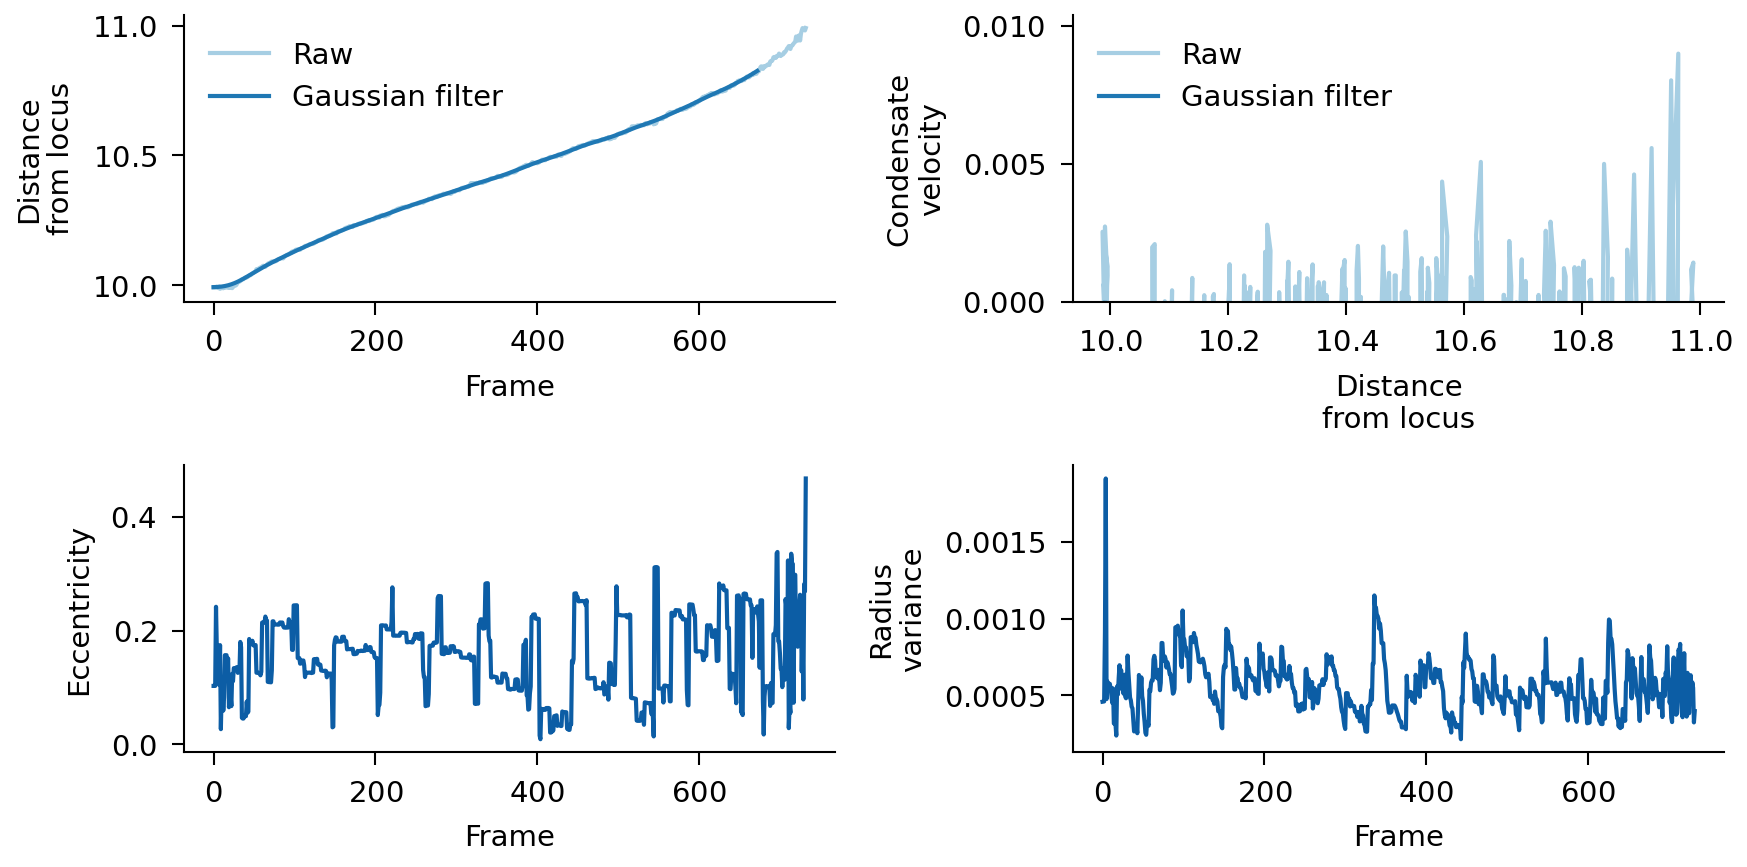

In [10]:
root = Path("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/20231017_flow/20231023_output/M1_1.0_beta_-0.25_gamma_-0.1_kappa_0.05_kprod_0.1_c1Init_3.5_noiseVar_0.0_rxnSigma_2.5_seed_5.5_loc_10")
condensate_property_plot(root)

In [6]:
folder =  Path("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/20231017_flow/20231023_output/M1_1.0_beta_-0.25_gamma_-0.1_kappa_0.05_kprod_0.1_c1Init_3.5_noiseVar_0.0_rxnSigma_2.5_seed_5.5_loc_10")
cmap = mpl.colormaps["Paired"].colors
sim = simDir(folder)
sim.run()
com, e, r = sim.condensate()

In [7]:
com = com[~np.isnan(com).any(axis=1),:]
e = e[~np.isnan(e)]
r = r[~np.isnan(r).any(axis=1),:]
x = np.arange(len(com[:,0]))
y = com[:,0]
f = gaussian_filter1d(y,15)

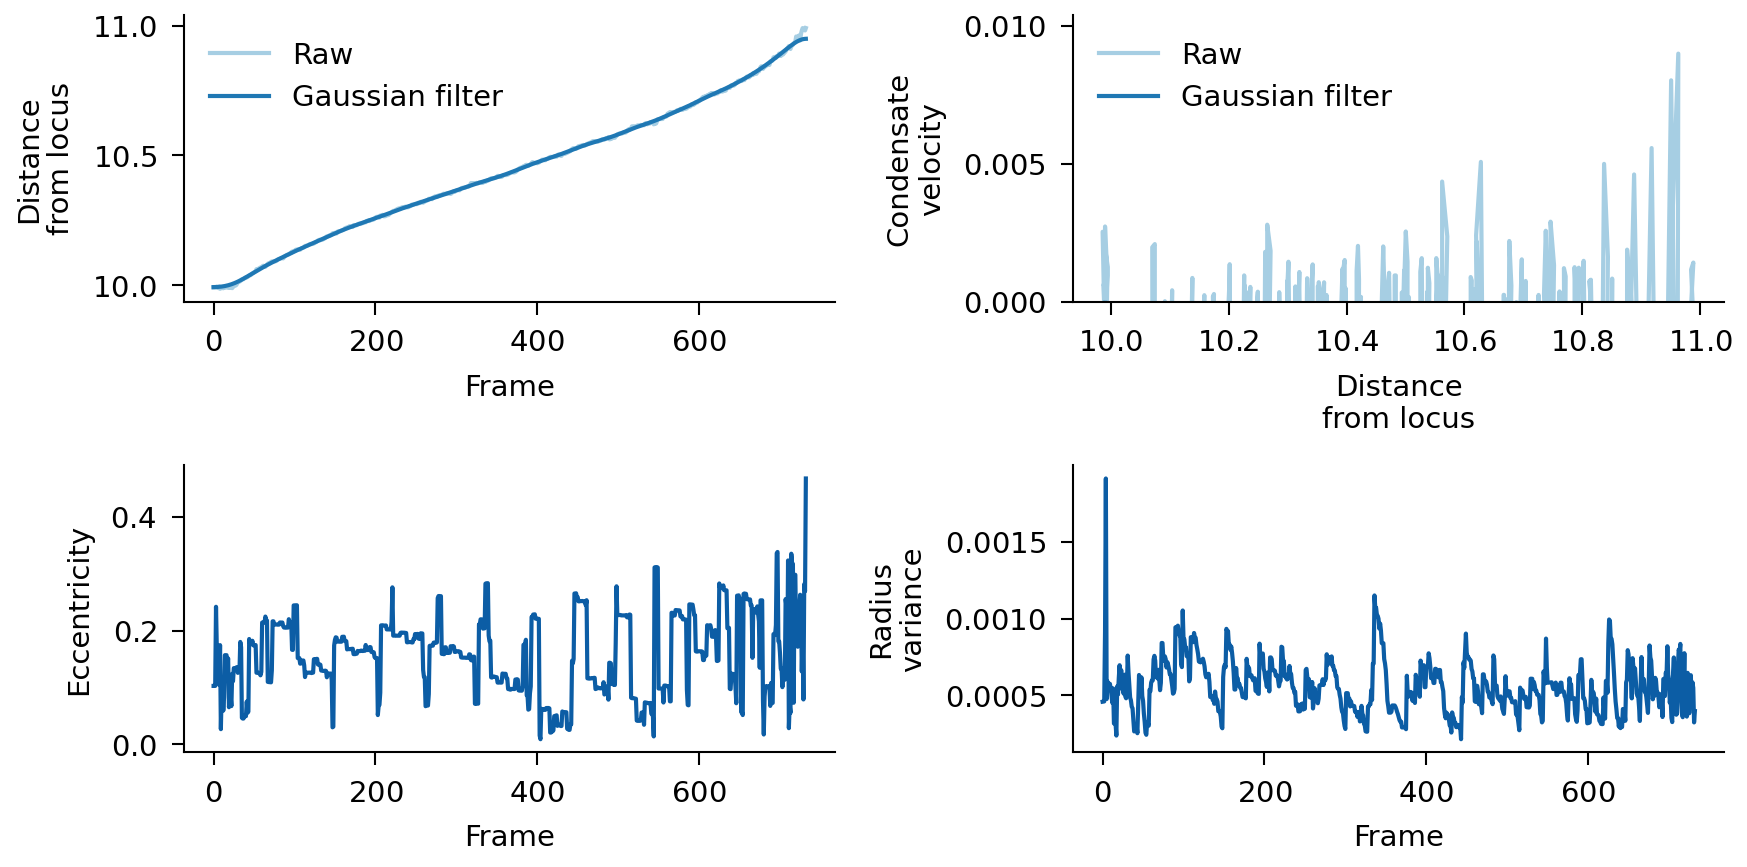

In [11]:
fig, ax = plt.subplots(2,2)
axes = np.ravel(ax)
fig.set_size_inches((6,3))
axes[0].plot(y,
                label="Raw",
                color=cmap[0])
axes[0].plot(f,
                label="Gaussian filter",
                color=cmap[1])
axes[0].legend()
axes[0].set_xlabel("Frame")
axes[0].set_ylabel("Distance\nfrom locus")
axes[1].plot(com[:,0],
                -np.gradient(y),
                label="Raw",
                color=cmap[0])
axes[1].plot(com[:,0],
                -np.gradient(f),
                label="Gaussian filter",
                color=cmap[1])
axes[1].set_xlabel("Distance\nfrom locus")
axes[1].set_ylim(bottom=0)
axes[1].set_ylabel("Condensate\nvelocity")
axes[1].legend()
axes[2].plot(e)
axes[2].set_ylabel("Eccentricity")
axes[2].set_xlabel("Frame")
var_r = np.var(r,axis=1)
axes[3].plot(var_r)
axes[3].set_ylabel("Radius\nvariance")
axes[3].set_xlabel("Frame")
fig.tight_layout()
# fig.savefig(folder / "figures" / "condensate.png")